In [1]:
import cv2
import numpy as np
import dlib
from math import hypot
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import socket 
import threading
global frame , gray
global isConn , result
isConn = 0

In [2]:
def connect():   
    soc = socket.socket()
    global conn,isConn
    soc.bind(('localhost',5555))
    soc.listen(5)
    conn , addr = soc.accept()
    isConn = 1
    print("device connected")

In [3]:
def SendMess(x):
    msg = bytes(f"{x}",'utf-8')
    conn.send(msg)

In [4]:
import cv2
import numpy as np
import dlib
from math import hypot
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
font = cv2.FONT_HERSHEY_PLAIN
def midpoint(p1 ,p2):
    return int((p1.x + p2.x)/2), int((p1.y + p2.y)/2)

def get_blinking_ratio(eye_points, facial_landmarks):
    left_point = (facial_landmarks.part(eye_points[0]).x, facial_landmarks.part(eye_points[0]).y)
    right_point = (facial_landmarks.part(eye_points[3]).x, facial_landmarks.part(eye_points[3]).y)
    center_top = midpoint(facial_landmarks.part(eye_points[1]), facial_landmarks.part(eye_points[2]))
    center_bottom = midpoint(facial_landmarks.part(eye_points[5]), facial_landmarks.part(eye_points[4]))

    hor_line_lenght = hypot((left_point[0] - right_point[0]), (left_point[1] - right_point[1]))
    ver_line_lenght = hypot((center_top[0] - center_bottom[0]), (center_top[1] - center_bottom[1]))

    ratio = hor_line_lenght / ver_line_lenght
    return ratio

def get_gaze_ratio(eye_points, facial_landmarks, gray_frame):
    left_eye_region = np.array([(facial_landmarks.part(eye_points[0]).x, facial_landmarks.part(eye_points[0]).y),
                                (facial_landmarks.part(eye_points[1]).x, facial_landmarks.part(eye_points[1]).y),
                                (facial_landmarks.part(eye_points[2]).x, facial_landmarks.part(eye_points[2]).y),
                                (facial_landmarks.part(eye_points[3]).x, facial_landmarks.part(eye_points[3]).y),
                                (facial_landmarks.part(eye_points[4]).x, facial_landmarks.part(eye_points[4]).y),
                                (facial_landmarks.part(eye_points[5]).x, facial_landmarks.part(eye_points[5]).y)], np.int32)

    #height, width, _ = gray_frame.shape
    gray_frame = gray_frame.astype(np.uint8)
    mask = np.zeros_like(gray_frame, np.uint8)
    cv2.polylines(mask, [left_eye_region], True, 255, 2)
    cv2.fillPoly(mask, [left_eye_region], 255)
    eye = cv2.bitwise_and(gray_frame, gray_frame, mask=mask)

    min_x = np.min(left_eye_region[:, 0])
    max_x = np.max(left_eye_region[:, 0])
    min_y = np.min(left_eye_region[:, 1])
    max_y = np.max(left_eye_region[:, 1])

    gray_eye = eye[min_y: max_y, min_x: max_x]
    _, threshold_eye = cv2.threshold(gray_eye, 70, 255, cv2.THRESH_BINARY)
    height, width = threshold_eye.shape
    left_side_threshold = threshold_eye[0: height, 0: int(width / 2)]
    left_side_white = cv2.countNonZero(left_side_threshold)

    right_side_threshold = threshold_eye[0: height, int(width / 2): width]
    right_side_white = cv2.countNonZero(right_side_threshold)

    if left_side_white == 0:
        gaze_ratio = 1
    elif right_side_white == 0:
        gaze_ratio = 5
    else:
        gaze_ratio = left_side_white / right_side_white
    return gaze_ratio

def gaze_tracking_and_heatmap():
    cap = cv2.VideoCapture(0)

    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

    gaze_points = []

    while True:
        _, frame = cap.read()
        new_frame = np.zeros((500, 500, 3), np.uint8)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        faces = detector(gray)

        for face in faces:
            landmarks = predictor(gray, face)

            # Detect blinking
            left_eye_ratio = get_blinking_ratio([36, 37, 38, 39, 40, 41], landmarks)
            right_eye_ratio = get_blinking_ratio([42, 43, 44, 45, 46, 47], landmarks)
            blinking_ratio = (left_eye_ratio + right_eye_ratio) / 2

            if blinking_ratio > 5.7:
                cv2.putText(frame, "BLINKING", (50, 150), font, 7, (255, 0, 0))

            # Gaze detection
            gaze_ratio_left_eye = get_gaze_ratio([36, 37, 38, 39, 40, 41], landmarks, gray)
            gaze_ratio_right_eye = get_gaze_ratio([42, 43, 44, 45, 46, 47], landmarks, gray)
            gaze_ratio = (gaze_ratio_right_eye + gaze_ratio_left_eye) / 2

            if gaze_ratio <= 1:
                cv2.putText(frame, "RIGHT", (50, 100), font, 2, (0, 0, 255), 3)
                new_frame[:] = (0, 0, 255)
            elif 1 < gaze_ratio < 1.7:
                cv2.putText(frame, "CENTER", (50, 100), font, 2, (0, 0, 255), 3)
            else:
                new_frame[:] = (255, 0, 0)
                cv2.putText(frame, "LEFT", (50, 100), font, 2, (0, 0, 255), 3)

            left_eye_x = landmarks.part(36).x
            left_eye_y = landmarks.part(36).y
            gaze_points.append((left_eye_x, left_eye_y))

        cv2.imshow("Frame", frame)
        cv2.imshow("New frame", new_frame)

        key = cv2.waitKey(1)
        if key == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

    # Save gaze points to CSV file
    with open("Points.csv", mode='a', newline='') as file:
        writer = csv.writer(file)
        for point in gaze_points:
            writer.writerow(point)

    # Read gaze points from CSV file
    df = pd.read_csv("Points.csv")

    # Convert list of tuples to DataFrame
    gaze_df = pd.DataFrame(df, columns=['x', 'y'])

    # Create a heatmap using seaborn
    sns.set(style="white")
    plt.figure(figsize=(8, 6))

    # Assuming your CSV file has 'gaze_ratio_left_eye' and 'gaze_ratio_right_eye' columns
    ax = sns.kdeplot(data=df, x='x', y='y', cmap="Blues", fill=True)

    # Overlay the points on the heatmap
    ax.scatter(gaze_df['x'], gaze_df['y'], color='red', marker='x', label='Gaze Points')

    plt.title("Gaze Heatmap with Points")
    plt.legend()
    plt.show()
    SendMess(gaze_points)


device connected


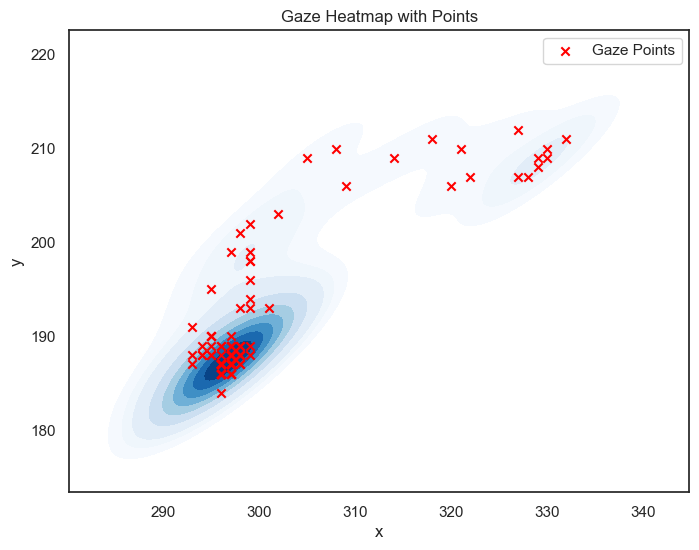

In [5]:
thread1 = threading.Thread(target=connect)
thread1.start()
thread1.join()

thread2 = threading.Thread(target=gaze_tracking_and_heatmap)
thread2.start()
thread2.join()